## NB - binary classification

In [1736]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [1737]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()

### tolgo record con outliers 

In [1738]:
pp_class = pp_class[pp_class["outlier_w_type"] != True]
pp_test_class = pp_test_class[pp_test_class["outlier_w_type"] != True]

### preprocessing variabili

In [1739]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)



In [1740]:
column2drop = ['originalTitle', 'runtimeMinutes']
pp_class.drop(column2drop, axis=1, inplace=True)
pp_test_class.drop(column2drop, axis=1, inplace=True)

#### Discretizzazione delle numeriche

In [1741]:
#train

#TOTALNOMINATIONS 
bins = [-1, 0, 2, 10, pp_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_class['totalNominations_bin'] = pd.cut(pp_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)
#TOTALMEDIA
bins = [-1, 0, 1, 8, 50, pp_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_class['totalMedia_bin'] = pd.cut(pp_class['totalMedia'], bins=bins, labels=labels)


#FILL_RUNTIMEMINS_BRUNO 
bins = [0, 30, 60, 90, pp_class['fill_runtimeMinutes_Bruno'].max()]
labels = ['0_VeryLowRuntime', '1_LowRuntime', '2_MediumRuntime', '3_HighRuntime']
pp_class['runtime_bin'] = pd.cut(pp_class['fill_runtimeMinutes_Bruno'], bins=bins, labels=labels)


#RATING 
bins = [-1, 3, 6, 7, 8, pp_class['rating'].max()]
labels = ['0_VeryLowRating', '1_LowRating', '2_MediumRating', '3_HighRating', "4_VeryHighRating"]
pp_class['rating_bin'] = pd.cut(pp_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['0_VeryLowVotes', '1_LowVotes', '2_MediumVotes', '3_HighVotes', '4_VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_class['numVotes_bin'] = pd.cut(pp_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1878,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_class['startYear'].max()] #era corrente
labels = ['0_pre-1930', '1_1930-1954', '2_1955-1979', '3_1980-1999', '4_2000-2019', '5_post-2020']
pp_class['startYear_bin'] = pd.cut(pp_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['0_VeryLowCredits', '1_LowCredits', '2_MediumCredits', '3_HighCredits']
bins = [-1, 15, 35, 65, float('inf')]
pp_class['totalCredits_bin'] = pd.cut(pp_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    '0_NoCriticReviews',
    '1_FewCriticReviews',
    '2_ModerateCriticReviews',
    '3_ManyCriticReviews',
    '4_VeryHighCriticReviews',
    '5_ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_class['criticReviewsTotal_bin'] = pd.cut(pp_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['0_FewRegions', '1_ModerateRegions', '2_ManyRegions']
bins = [0, 1, 8, float('inf')]
pp_class['numRegions_bin'] = pd.cut(pp_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['0_NoUserReviews', '1_FewUserReviews', '2_ManyUserReviews', '3_VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]
pp_class['userReviewsTotal_bin'] = pd.cut(pp_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN freq-> 
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['0_LowFreqCountries', '1_MediumFreqCountries', '2_HighFreqCountries']
pp_class["country_freq_bin"] = pd.cut( pp_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> 
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'1_is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_class, "countryOfOrigin_UNK", "from_Unknown")



In [1742]:
#train

#TOTALNOMINATIONS 
bins = [-1, 0, 2, 10, pp_test_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_test_class['totalNominations_bin'] = pd.cut(pp_test_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)


#TOTALMEDIA
bins = [-1, 0, 1, 8, 50, pp_test_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_test_class['totalMedia_bin'] = pd.cut(pp_test_class['totalMedia'], bins=bins, labels=labels)


#FILL_RUNTIMEMINS_BRUNO 
bins = [0, 30, 60, 90, pp_test_class['fill_runtimeMinutes_Bruno'].max()]
labels = ['0_VeryLowRuntime', '1_LowRuntime', '2_MediumRuntime', '3_HighRuntime']
pp_test_class['runtime_bin'] = pd.cut(pp_test_class['fill_runtimeMinutes_Bruno'], bins=bins, labels=labels)


#RATING 
bins = [-1, 3, 6, 7, 8, pp_test_class['rating'].max()]
labels = ['0_VeryLowRating', '1_LowRating', '2_MediumRating', '3_HighRating', "4_VeryHighRating"]
pp_test_class['rating_bin'] = pd.cut(pp_test_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['0_VeryLowVotes', '1_LowVotes', '2_MediumVotes', '3_HighVotes', '4_VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_test_class['numVotes_bin'] = pd.cut(pp_test_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1877,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_test_class['startYear'].max()] #era corrente
labels = ['0_pre-1930', '1_1930-1954', '2_1955-1979', '3_1980-1999', '4_2000-2019', '5_post-2020']
pp_test_class['startYear_bin'] = pd.cut(pp_test_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['0_VeryLowCredits', '1_LowCredits', '2_MediumCredits', '3_HighCredits']
bins = [-1, 15, 35, 65, float('inf')]

pp_test_class['totalCredits_bin'] = pd.cut(pp_test_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    '0_NoCriticReviews',
    '1_FewCriticReviews',
    '2_ModerateCriticReviews',
    '3_ManyCriticReviews',
    '4_VeryHighCriticReviews',
    '5_ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_test_class['criticReviewsTotal_bin'] = pd.cut(pp_test_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['0_FewRegions', '1_ModerateRegions', '2_ManyRegions']
bins = [0, 1, 8, float('inf')]
pp_test_class['numRegions_bin'] = pd.cut(pp_test_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['0_NoUserReviews', '1_FewUserReviews', '2_ManyUserReviews', '3_VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]

pp_test_class['userReviewsTotal_bin'] = pd.cut(pp_test_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN FREQ ENC 
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['0_LowFreqCountries', '1_MediumFreqCountries', '2_HighFreqCountries']

pp_test_class["country_freq_bin"] = pd.cut( pp_test_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> 
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'1_is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_test_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_test_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_test_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_test_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_test_class, "countryOfOrigin_UNK", "from_Unknown")

#### one hot encoding titletype -> prob non serve

In [1743]:
# title_type_dummies_tr = pd.get_dummies(pp_class['titleType'], prefix='titleType').astype(int)
# title_type_dummies_ts = pd.get_dummies(pp_test_class['titleType'], prefix='titleType').astype(int)

# pp_class = pd.concat([pp_class, title_type_dummies_tr], axis=1)
# pp_test_class = pd.concat([pp_test_class, title_type_dummies_ts], axis=1)

# #0 falso - 1 vero
# pp_class.head()

## Variabile target

In [1744]:
pp_class["has_lowEngagement"] = (pp_class["numVotes"]<100).astype(int)
pp_test_class["has_lowEngagement"] = (pp_test_class["numVotes"]<100).astype(int)

x = sum(pp_class["has_lowEngagement"] == 1)
x

10287

In [1745]:
y_train = np.array(pp_class["has_lowEngagement"]) #target originale
y_test = np.array(pp_test_class["has_lowEngagement"])

## Scelta feature (NO USERREVIEWS)

In [1746]:

features =[
       'rating_bin',
       'totalCredits_bin', 
       'canHaveEpisodes', 
       'numRegions_bin', 
       'country_freq_bin',
      # 'runtime_bin',  # peggiora legggermente le performance
       'totalNominations_bin',
       'totalMedia_bin',
       'startYear_bin',

      'criticReviewsTotal_bin',
       # 'userReviewsTotal_bin',

     # 'titleType', # meglio delle one-hot encoding -> catNB preferisce che ogni feature si auna categoria unica

       'from_NorthAmerica_bin','from_Europe_bin' ,
      #  'from_SouthAmerica_bin',  'from_Asia_bin', 'from_Oceania_bin', 'from_Africa_bin', 
       # 'from_Unknown_bin',

      "is_Documentary", "is_History", "is_Adventure", "is_Thriller", "is_Game-Show", "is_Comedy", "is_Sci-Fi", "is_Romance", "is_Biography",
         "is_Musical", "is_Western", "is_Music", "is_Film-Noir", "is_Adult", "is_Reality-TV", "is_News", "is_Action", "is_Crime", "is_Short", 
        "is_Fantasy", "is_Family", "is_Mystery", "is_Talk-Show", "is_Drama", "is_Sport", "is_War", "is_Horror", "is_Animation"


]

X_train = pp_class[features].values
X_test = pp_test_class[features].values

In [1747]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train= encoder.fit_transform(X_train)  # dove X ha solo colonne categoriche (incluse le binned)
X_test= encoder.transform(X_test)  # dove X ha solo colonne categoriche (incluse le binned)


### Splitting in validation

In [1748]:
#CATEGORICAL NB
X_train2, X_val, y_train2, y_val = train_test_split(
      X_train, y_train, test_size=0.2, random_state=32)

In [1749]:
print(X_train2.shape, X_val.shape, X_train.shape,
      #, X_test.shape
      )

(11964, 39) (2991, 39) (14955, 39)


In [1750]:

X_train2_tr = X_train2
X_val_tr = X_val

X_train_tr = X_train
X_test_tr = X_test

## NAIVE BAYES

### Categorical

In [1751]:
#clf = GaussianNB()
#clf = ComplementNB(alpha=1.0) -> non va perchè ci sono valori negativi
clf = CategoricalNB()
clf.fit(X_train2_tr, y_train2)

CategoricalNB()

### Predicting on validation set

In [1752]:
y_pred = clf.predict(X_val_tr)

In [1753]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

2991
2991


In [1754]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1}
{0, 1}


Classification report

In [1755]:
class_names = ['high_engagement', 'low_engagement']

print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))

Test accuracy: 0.8304914744232698

Classification Report:
                 precision    recall  f1-score   support

high_engagement       0.74      0.70      0.72       938
 low_engagement       0.87      0.89      0.88      2053

       accuracy                           0.83      2991
      macro avg       0.81      0.80      0.80      2991
   weighted avg       0.83      0.83      0.83      2991



In [1756]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[0.84529755, 0.15470245],
       [0.00722302, 0.99277698],
       [0.94842179, 0.05157821],
       ...,
       [0.03363574, 0.96636426],
       [0.01339938, 0.98660062],
       [0.2855332 , 0.7144668 ]])

overfitting

Performance sul Training set:
Accuracy: 0.8294
F1 Score: 0.8272

Performance sul Validation set:
Accuracy: 0.8305
F1 Score: 0.8292


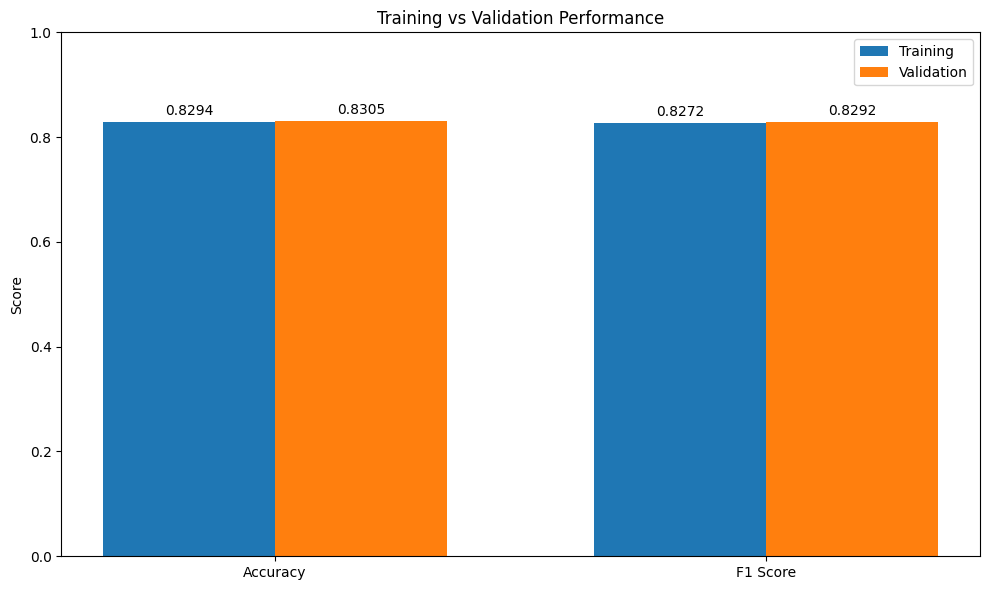

In [1757]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

ROC curve

In [1758]:
print("y_val shape:", y_val.shape)
print("y_val dtype:", y_val.dtype)
print("primi elementi di y_val:", y_val[:5])  # Mostra i primi 5 elementi

y_val shape: (2991,)
y_val dtype: int32
primi elementi di y_val: [1 1 0 1 1]


In [1759]:
# plot_roc(y_val, clf.predict_proba(X_val_tr))
# plt.show()
# print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

prova 2 roc

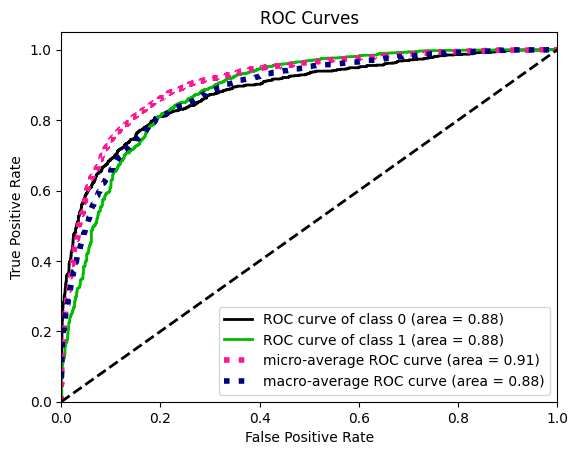

0.8815493889539153


In [1760]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_val_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_val, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_val, probs[:, 1]))

Confusion matrix

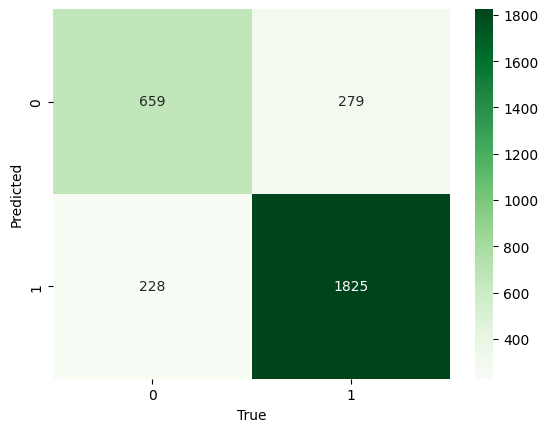

In [1761]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

Distribuzioni classi nel train2

In [1762]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    3730
1    8234
Name: count, dtype: int64


## Proper testing on the test set

In [1763]:
#clf = GaussianNB()
clf = CategoricalNB()
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_test_tr)
y_pred

array([1, 0, 1, ..., 1, 0, 1])

Performance sul Training set:
Accuracy: 0.8290
F1 Score: 0.8269

Performance sul test set:
Accuracy: 0.8324
F1 Score: 0.8304


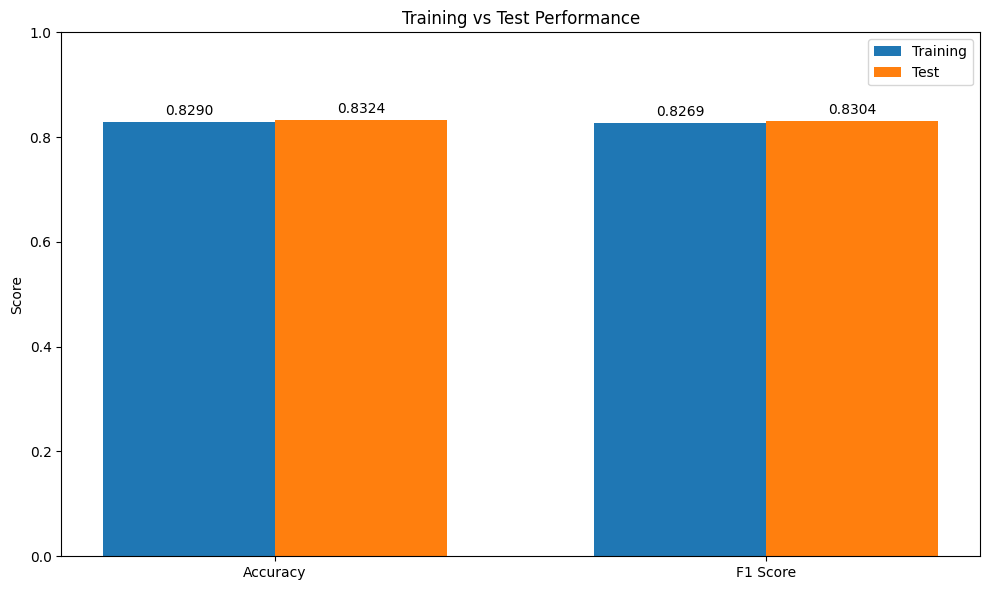

In [1764]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_tr)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_tr)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
                        ### gaia ha messo y_tpred

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [1765]:
class_names = ['high_engagement', 'low_engagement']

print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred,target_names=class_names))

Test accuracy: 0.8324291742013261

Classification Report:
                 precision    recall  f1-score   support

high_engagement       0.75      0.69      0.72      1561
 low_engagement       0.86      0.90      0.88      3416

       accuracy                           0.83      4977
      macro avg       0.81      0.79      0.80      4977
   weighted avg       0.83      0.83      0.83      4977



In [1766]:
clf.predict_proba(X_test_tr)
#prob che un record appartenga alle classi

array([[0.00912141, 0.99087859],
       [0.95315691, 0.04684309],
       [0.01397162, 0.98602838],
       ...,
       [0.00621372, 0.99378628],
       [0.88768175, 0.11231825],
       [0.01267507, 0.98732493]])

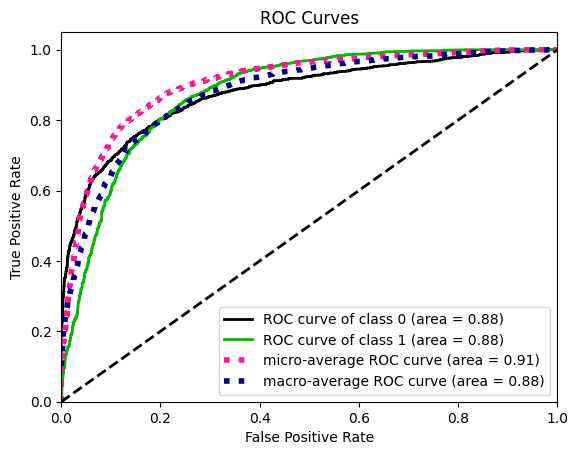

0.8779483104717296


In [1767]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_test_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_test, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_test, probs[:, 1]))

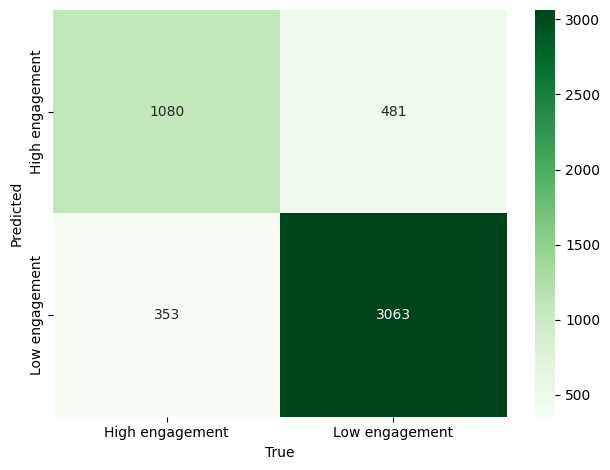

In [1768]:
class_names = ['High engagement', 'Low engagement']

classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()




### Dummy classifier

In [1769]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tr, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_tr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6863572433192686
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1561
           1       0.69      1.00      0.81      3416

    accuracy                           0.69      4977
   macro avg       0.34      0.50      0.41      4977
weighted avg       0.47      0.69      0.56      4977



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
